In [50]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import ast


In [26]:
tracks = pd.read_csv("supervised_music_challenge_data/tracks.tsv", sep="\t", dtype={"track_id": str})
echonest = pd.read_csv("supervised_music_challenge_data/echonest_features.tsv", sep="\t", dtype={"track_id": str})
spectral = pd.read_csv("supervised_music_challenge_data/spectral_features.tsv", sep="\t", dtype={"track_id": str})
genres = pd.read_csv("supervised_music_challenge_data/genres.csv")


In [27]:
print("tracks_columns :", tracks.columns)
print("echonest_columns :", echonest.columns)
print("spectral_columns :", spectral.columns)   
print("genres_columns :", genres.columns)

tracks_columns : Index(['track_id', 'album_title', 'album_tracks', 'artist_latitude',
       'artist_longitude', 'artist_name', 'duration', 'favorites', 'genre_top',
       'genres', 'genres_all', 'interest', 'listens', 'title'],
      dtype='object')
echonest_columns : Index(['track_id', 'acousticness', 'danceability', 'energy',
       'instrumentalness', 'liveness', 'speechiness', 'tempo', 'valence'],
      dtype='object')
spectral_columns : Index(['track_id', 'spectral_bandwidth_kurtosis_01',
       'spectral_bandwidth_max_01', 'spectral_bandwidth_mean_01',
       'spectral_bandwidth_median_01', 'spectral_bandwidth_min_01',
       'spectral_bandwidth_skew_01', 'spectral_bandwidth_std_01',
       'spectral_centroid_kurtosis_01', 'spectral_centroid_max_01',
       'spectral_centroid_mean_01', 'spectral_centroid_median_01',
       'spectral_centroid_min_01', 'spectral_centroid_skew_01',
       'spectral_centroid_std_01', 'spectral_rolloff_kurtosis_01',
       'spectral_rolloff_max_01',

In [28]:
def clean_cols(df):
    df.columns = (df.columns
                    .str.lower()
                    .str.strip()
                    .str.replace(" ", "_")
                    .str.replace("-", "_")
                    .str.replace(r"[^a-zA-Z0-9_]", "", regex=True))
    return df
        
tracks = clean_cols(tracks)
echonest = clean_cols(echonest)
spectral = clean_cols(spectral)
genres = clean_cols(genres)


In [29]:
df = tracks.merge(echonest, on="track_id", how="left") \
           .merge(spectral, on="track_id", how="left")


In [30]:
df.to_csv("tracks_merged.csv", index=False) # Les 3 fichiers merged 

In [31]:
#Création de colonnes pour les genres

genres_df = pd.read_csv("supervised_music_challenge_data/genres.csv")

genres_df = genres_df.rename(columns={
    "genre_id": "id",
    "genre_title": "name"
})

# dictionnaire : id -> nom
id_to_name = dict(zip(genres_df["id"], genres_df["name"]))




In [32]:
type(df.loc[0, "genres"])


str

In [33]:
df["genres"] = df["genres"].apply(ast.literal_eval)
df["genres_all"] = df["genres_all"].apply(ast.literal_eval)


In [34]:
def ids_to_names(id_list):
    return [id_to_name.get(i, "UNKNOWN") for i in id_list]


In [35]:
df["genres_names"] = df["genres"].apply(ids_to_names)
df["genres_all_names"] = df["genres_all"].apply(ids_to_names)


In [36]:
df[["genre_top", "genres_names", "genres_all_names"]].head()


,genre_top,genres_names,genres_all_names
0,Hip-Hop,[Hip-Hop],[Hip-Hop]
1,Hip-Hop,[Hip-Hop],[Hip-Hop]
2,Hip-Hop,[Hip-Hop],[Hip-Hop]
3,Hip-Hop,[Hip-Hop],[Hip-Hop]
4,Hip-Hop,[Hip-Hop],[Hip-Hop]


In [37]:
df.to_csv("genres_named.csv", index=False) #merge de df mais avec les noms de genre

In [38]:
# 1. Informations générales
print("Shape du dataset:", df.shape)
print("\nTypes de données:")
print(df.dtypes)


Shape du dataset: (99995, 45)

Types de données:
track_id                           object
album_title                        object
album_tracks                        int64
artist_latitude                   float64
artist_longitude                  float64
artist_name                        object
duration                            int64
favorites                           int64
genre_top                          object
genres                             object
genres_all                         object
interest                            int64
listens                             int64
title                              object
acousticness                      float64
danceability                      float64
energy                            float64
instrumentalness                  float64
liveness                          float64
speechiness                       float64
tempo                             float64
valence                           float64
spectral_bandwidth_kurtosis

In [39]:
df.head()

,track_id,album_title,album_tracks,artist_latitude,artist_longitude,artist_name,duration,favorites,genre_top,genres,...,spectral_centroid_std_01,spectral_rolloff_kurtosis_01,spectral_rolloff_max_01,spectral_rolloff_mean_01,spectral_rolloff_median_01,spectral_rolloff_min_01,spectral_rolloff_skew_01,spectral_rolloff_std_01,genres_names,genres_all_names
0,11870,Wildahead Portibeast,10,NaN,NaN,Wildahead Portibeast,131,0,Hip-Hop,[21],...,575.112488,2.839292,8968.579102,2338.119629,1981.054688,516.796875,1.812383,1234.268433,[Hip-Hop],[Hip-Hop]
1,11871,Wildahead Portibeast,10,NaN,NaN,Wildahead Portibeast,185,0,Hip-Hop,[21],...,655.114319,2.036670,9560.742188,2132.796143,1830.322266,226.098633,1.412759,1387.095459,[Hip-Hop],[Hip-Hop]
2,11872,Wildahead Portibeast,10,NaN,NaN,Wildahead Portibeast,183,0,Hip-Hop,[21],...,645.915894,-0.463741,9345.410156,2760.100342,2583.984375,64.599609,0.245426,1420.888672,[Hip-Hop],[Hip-Hop]
3,11873,Wildahead Portibeast,10,NaN,NaN,Wildahead Portibeast,213,3,Hip-Hop,[21],...,615.655090,-0.114326,9722.241211,2445.449219,2271.752930,86.132812,0.581035,1330.056030,[Hip-Hop],[Hip-Hop]
4,11874,Wildahead Portibeast,10,NaN,NaN,Wildahead Portibeast,162,0,Hip-Hop,[21],...,755.226440,4.567743,10142.138672,2265.638672,1905.688477,215.332031,1.849876,1474.148682,[Hip-Hop],[Hip-Hop]


In [40]:
# 2. Valeurs manquantes
print("\n=== VALEURS MANQUANTES ===")
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing_Count': missing,
    'Percentage': missing_pct
}).sort_values('Percentage', ascending=False)
print(missing_df[missing_df['Missing_Count'] > 0])



=== VALEURS MANQUANTES ===
                  Missing_Count  Percentage
speechiness               89587   89.591480
valence                   89463   89.467473
danceability              89461   89.465473
energy                    89442   89.446472
liveness                  89442   89.446472
acousticness              89442   89.446472
tempo                     89442   89.446472
instrumentalness          89442   89.446472
artist_longitude          59788   59.790990
artist_latitude           59788   59.790990
genre_top                 55362   55.364768
album_title                 911    0.911046
title                         1    0.001000


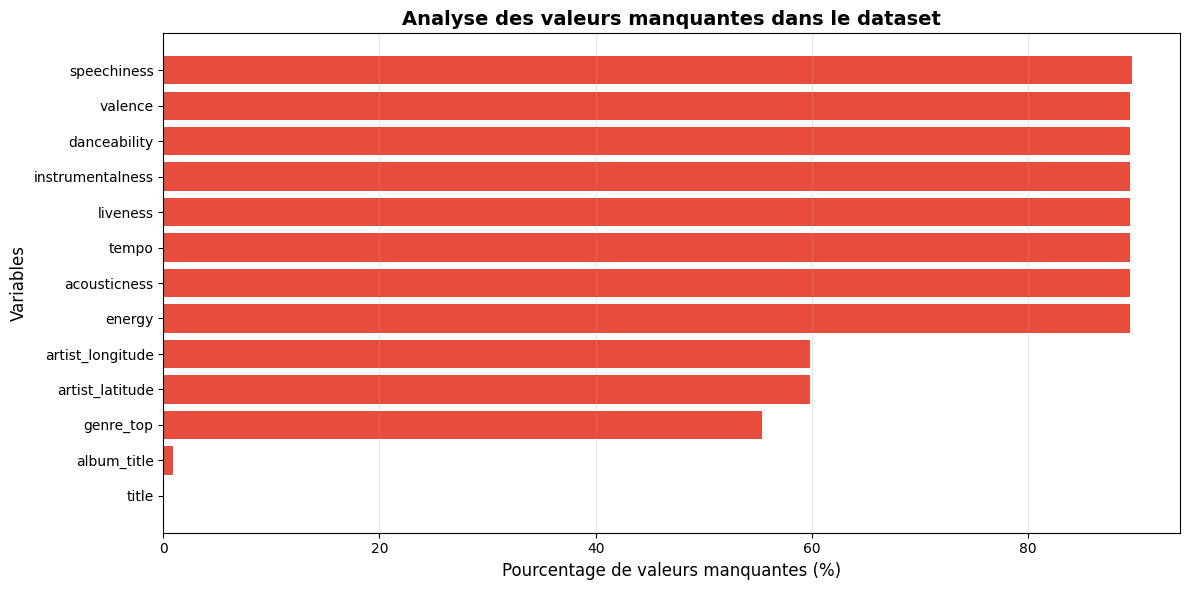

In [44]:

# Filtrer et trier
missing_to_plot = missing_df[missing_df['Percentage'] > 0].sort_values('Percentage')

# Créer le graphique
fig, ax = plt.subplots(figsize=(12, 6))
ax.barh(missing_to_plot.index, missing_to_plot['Percentage'], color='#e74c3c')

ax.set_xlabel('Pourcentage de valeurs manquantes (%)', fontsize=12)
ax.set_ylabel('Variables', fontsize=12)
ax.set_title('Analyse des valeurs manquantes dans le dataset', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()



=== CORRÉLATION ENTRE MISSING VALUES ===

Nombre de variables avec missing values: 13

Corrélations fortes (> 0.5):
  speechiness <-> valence: 0.993
  speechiness <-> danceability: 0.993
  speechiness <-> energy: 0.992
  speechiness <-> liveness: 0.992
  speechiness <-> acousticness: 0.992
  speechiness <-> tempo: 0.992
  speechiness <-> instrumentalness: 0.992
  valence <-> danceability: 1.000
  valence <-> energy: 0.999
  valence <-> liveness: 0.999
  valence <-> acousticness: 0.999
  valence <-> tempo: 0.999
  valence <-> instrumentalness: 0.999
  danceability <-> energy: 0.999
  danceability <-> liveness: 0.999
  danceability <-> acousticness: 0.999
  danceability <-> tempo: 0.999
  danceability <-> instrumentalness: 0.999
  energy <-> liveness: 1.000
  energy <-> acousticness: 1.000
  energy <-> tempo: 1.000
  energy <-> instrumentalness: 1.000
  liveness <-> acousticness: 1.000
  liveness <-> tempo: 1.000
  liveness <-> instrumentalness: 1.000
  acousticness <-> tempo: 1.000
  a

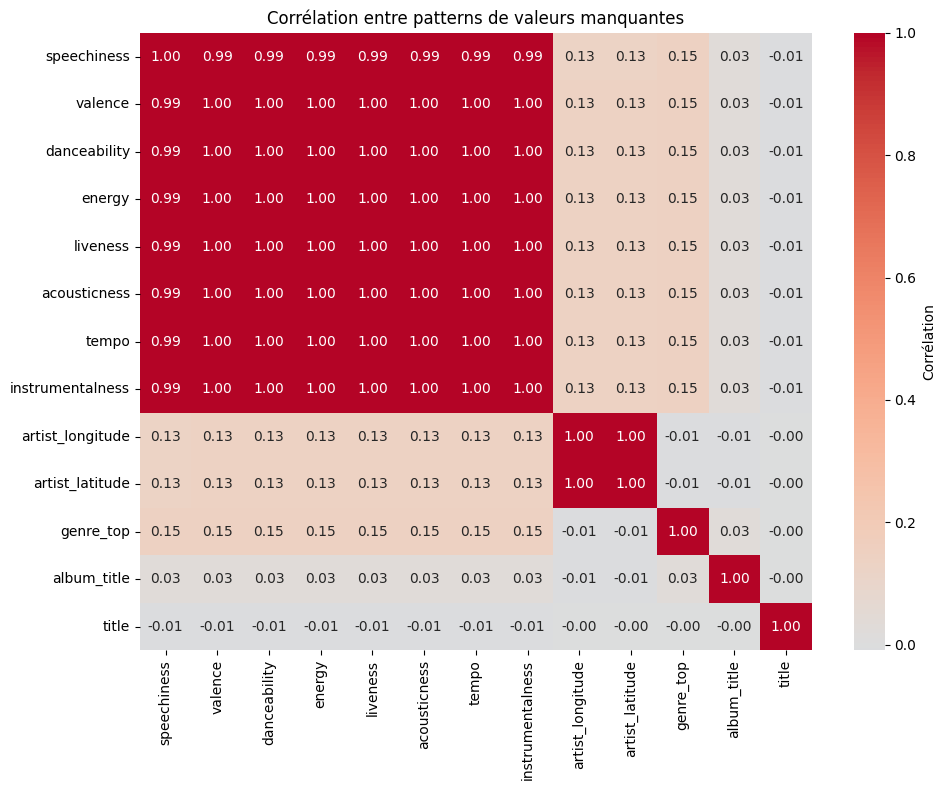

In [46]:
# Analyser si les missing values sont corrélés entre variables
print("\n=== CORRÉLATION ENTRE MISSING VALUES ===")
missing_cols = missing_df[missing_df['Missing_Count'] > 0].index.tolist()

if len(missing_cols) > 1:
    # Créer une matrice binaire (1 = missing, 0 = present)
    missing_matrix = df[missing_cols].isnull().astype(int)
    
    # Calculer la corrélation
    missing_corr = missing_matrix.corr()
    
    print(f"\nNombre de variables avec missing values: {len(missing_cols)}")
    print("\nCorrélations fortes (> 0.5):")
    
    # Afficher seulement les corrélations fortes
    for i in range(len(missing_corr.columns)):
        for j in range(i+1, len(missing_corr.columns)):
            corr_val = missing_corr.iloc[i, j]
            if abs(corr_val) > 0.5:
                print(f"  {missing_corr.columns[i]} <-> {missing_corr.columns[j]}: {corr_val:.3f}")
    
    # Heatmap si pas trop de variables
    if len(missing_cols) <= 15:
        import seaborn as sns
        
        fig, ax = plt.subplots(figsize=(10, 8))
        sns.heatmap(missing_corr, annot=True, fmt='.2f', cmap='coolwarm', 
                    center=0, ax=ax, cbar_kws={'label': 'Corrélation'})
        plt.title('Corrélation entre patterns de valeurs manquantes')
        plt.tight_layout()
        plt.show()
else:
    print("Une seule variable a des missing values, pas de corrélation à calculer.")


In [ ]:
# 3. Doublons
print(f"\nNombre de doublons (track_id): {df['track_id'].duplicated().sum()}")



Nombre de doublons (track_id): 0


In [ ]:
# 4. Statistiques descriptives
print("\n=== STATISTIQUES DESCRIPTIVES ===")
print(df[['duration', 'listens', 'interest', 'favorites']].describe())




=== STATISTIQUES DESCRIPTIVES ===
           duration        listens      interest     favorites
count  99995.000000   99995.000000  9.999500e+04  99995.000000
mean     278.034522    2403.072944  3.628631e+03      3.239962
std      294.940279    8234.085292  1.957852e+04     13.863871
min        0.000000       0.000000  2.000000e+00      0.000000
25%      151.000000     305.000000  6.020000e+02      0.000000
50%      218.000000     797.000000  1.333000e+03      1.000000
75%      307.000000    2085.000000  3.117000e+03      3.000000
max    11030.000000  543252.000000  3.293557e+06   1482.000000


In [51]:
print("\n" + "="*60)
print("DÉTECTION D'INCOHÉRENCES")
print("="*60)

# 1. DURÉE (variable cible pour Task 3)
print("\n--- DURÉE (duration) ---")
print(f"Durées négatives: {(df['duration'] < 0).sum()}")
print(f"Durées nulles (= 0): {(df['duration'] == 0).sum()}")
print(f"Durées très courtes (< 30s): {(df['duration'] < 30).sum()}")
print(f"Durées très longues (> 600s = 10min): {(df['duration'] > 600).sum()}")
print(f"Durées extrêmes (> 3600s = 1h): {(df['duration'] > 3600).sum()}")
print(f"\nMin duration: {df['duration'].min()}s")
print(f"Max duration: {df['duration'].max()}s")

# 2. COORDONNÉES GPS
print("\n--- COORDONNÉES GPS ---")
if 'artist_latitude' in df.columns and 'artist_longitude' in df.columns:
    print(f"Latitudes hors [-90, 90]: {((df['artist_latitude'] < -90) | (df['artist_latitude'] > 90)).sum()}")
    print(f"Longitudes hors [-180, 180]: {((df['artist_longitude'] < -180) | (df['artist_longitude'] > 180)).sum()}")
    print(f"Coordonnées (0, 0) - probablement invalides: {((df['artist_latitude'] == 0) & (df['artist_longitude'] == 0)).sum()}")

# 3. FEATURES ECHONEST (doivent être entre 0 et 1)
print("\n--- FEATURES ECHONEST (doivent être [0, 1]) ---")
audio_features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 
                  'liveness', 'speechiness', 'valence']

for feat in audio_features:
    if feat in df.columns:
        out_of_range = ((df[feat] < 0) | (df[feat] > 1)).sum()
        if out_of_range > 0:
            print(f"  ⚠️ {feat} hors [0,1]: {out_of_range} valeurs")
        else:
            print(f"  ✓ {feat}: OK")

# 4. TEMPO (devrait être positif et raisonnable)
print("\n--- TEMPO ---")
if 'tempo' in df.columns:
    print(f"Tempo négatif: {(df['tempo'] < 0).sum()}")
    print(f"Tempo = 0: {(df['tempo'] == 0).sum()}")
    print(f"Tempo très élevé (> 300 BPM): {(df['tempo'] > 300).sum()}")
    print(f"Range: [{df['tempo'].min():.1f}, {df['tempo'].max():.1f}] BPM")

# 5. FEATURES SPECTRALES (vérifier valeurs infinies/NaN)
print("\n--- FEATURES SPECTRALES ---")
spectral_cols = [col for col in df.columns if 'spectral' in col]
if spectral_cols:
    print(f"Valeurs infinies: {np.isinf(df[spectral_cols]).sum().sum()}")
    print(f"NaN dans spectrales (en plus des missing): {df[spectral_cols].isna().sum().sum()}")
    
    # Vérifier valeurs négatives (certaines features peuvent être négatives)
    negative_spectral = (df[spectral_cols] < 0).sum().sum()
    print(f"Valeurs négatives: {negative_spectral}")

# 6. STATISTIQUES D'ÉCOUTE
print("\n--- STATISTIQUES D'ÉCOUTE ---")
if 'listens' in df.columns:
    print(f"Listens négatifs: {(df['listens'] < 0).sum()}")
    print(f"Listens = 0: {(df['listens'] == 0).sum()}")
    
if 'interest' in df.columns:
    print(f"Interest négatif: {(df['interest'] < 0).sum()}")
    print(f"Interest = 0: {(df['interest'] == 0).sum()}")

if 'favorites' in df.columns:
    print(f"Favorites négatifs: {(df['favorites'] < 0).sum()}")

# 7. GENRE_TOP (variable cible Task 1)
print("\n--- GENRE_TOP (target Task 1) ---")
print(f"Genre_top manquants: {df['genre_top'].isnull().sum()}")
print(f"Genres uniques: {df['genre_top'].nunique()}")



DÉTECTION D'INCOHÉRENCES

--- DURÉE (duration) ---
Durées négatives: 0
Durées nulles (= 0): 4
Durées très courtes (< 30s): 1754
Durées très longues (> 600s = 10min): 5527
Durées extrêmes (> 3600s = 1h): 123

Min duration: 0s
Max duration: 11030s

--- COORDONNÉES GPS ---
Latitudes hors [-90, 90]: 0
Longitudes hors [-180, 180]: 0
Coordonnées (0, 0) - probablement invalides: 0

--- FEATURES ECHONEST (doivent être [0, 1]) ---
  ✓ acousticness: OK
  ✓ danceability: OK
  ✓ energy: OK
  ✓ instrumentalness: OK
  ✓ liveness: OK
  ✓ speechiness: OK
  ✓ valence: OK

--- TEMPO ---
Tempo négatif: 0
Tempo = 0: 19
Tempo très élevé (> 300 BPM): 0
Range: [0.0, 251.1] BPM

--- FEATURES SPECTRALES ---
Valeurs infinies: 0
NaN dans spectrales (en plus des missing): 0
Valeurs négatives: 94478

--- STATISTIQUES D'ÉCOUTE ---
Listens négatifs: 0
Listens = 0: 1
Interest négatif: 0
Interest = 0: 0
Favorites négatifs: 0

--- GENRE_TOP (target Task 1) ---
Genre_top manquants: 55362
Genres uniques: 16


In [59]:
print("="*60)
print("IMPACT DU NETTOYAGE")
print("="*60)

# Dataset de départ
print(f"Dataset initial: {len(df)} lignes")

# Duration invalides (seulement ≤0)
invalid_duration = (df['duration'] <= 0).sum()
print(f"Duration invalides (≤0): {invalid_duration} ({(invalid_duration/len(df)*100):.2f}%)")

# Dataset final après nettoyage
df_clean = df[
    (df['duration'] > 0)  # Supprimer uniquement durées nulles ou négatives
].copy()

# Traiter tempo = 0
df_clean.loc[df_clean['tempo'] == 0, 'tempo'] = np.nan

print(f"\n✓ Dataset nettoyé: {len(df_clean)} lignes ({(len(df_clean)/len(df)*100):.2f}% conservé)")
print(f"✗ Lignes supprimées: {len(df) - len(df_clean)}")

# Statistiques duration
print(f"\n--- STATISTIQUES DURATION ---")
print(f"Min: {df_clean['duration'].min()}s")
print(f"Max: {df_clean['duration'].max()}s ({df_clean['duration'].max()/60:.1f} minutes)")
print(f"Moyenne: {df_clean['duration'].mean():.1f}s")
print(f"Médiane: {df_clean['duration'].median():.1f}s")
print(f"Durées > 1h (3600s): {(df_clean['duration'] > 3600).sum()} conservées")

# Sauvegarder
df_clean.to_csv("tracks_cleaned.csv", index=False)
print("\n✓ Sauvegardé: tracks_cleaned.csv")



IMPACT DU NETTOYAGE
Dataset initial: 99995 lignes
Duration invalides (≤0): 4 (0.00%)

✓ Dataset nettoyé: 99991 lignes (100.00% conservé)
✗ Lignes supprimées: 4

--- STATISTIQUES DURATION ---
Min: 1s
Max: 11030s (183.8 minutes)
Moyenne: 278.0s
Médiane: 218.0s
Durées > 1h (3600s): 123 conservées

✓ Sauvegardé: tracks_cleaned.csv


In [60]:
print("\n" + "="*60)
print("STATISTIQUES DESCRIPTIVES")
print("="*60)

# Variables numériques principales
numeric_cols = ['duration', 'listens', 'interest', 'favorites', 'tempo',
                'acousticness', 'danceability', 'energy', 'instrumentalness',
                'liveness', 'speechiness', 'valence']

print(df_clean[numeric_cols].describe())

# Statistiques par genre (si disponible)
print("\n--- DURATION PAR GENRE (top 10) ---")
if df_clean['genre_top'].notna().sum() > 0:
    genre_duration = df_clean[df_clean['genre_top'].notna()].groupby('genre_top')['duration'].agg(['count', 'mean', 'median', 'std'])
    print(genre_duration.sort_values('mean', ascending=False))

# Valeurs manquantes après nettoyage
print("\n--- VALEURS MANQUANTES ---")
missing = df_clean.isnull().sum()
missing_pct = (missing / len(df_clean)) * 100
missing_df = pd.DataFrame({
    'Count': missing,
    'Percentage': missing_pct
}).sort_values('Percentage', ascending=False)
print(missing_df[missing_df['Count'] > 0].head(15))



STATISTIQUES DESCRIPTIVES
           duration        listens      interest     favorites         tempo  \
count  99991.000000   99991.000000  9.999100e+04  99991.000000  10534.000000   
mean     278.045644    2402.971797  3.628530e+03      3.240002    122.667999   
std      294.940936    8234.228670  1.957890e+04     13.864146     34.568381   
min        1.000000       0.000000  2.000000e+00      0.000000     12.753000   
25%      151.000000     305.000000  6.020000e+02      0.000000     95.880250   
50%      218.000000     797.000000  1.333000e+03      1.000000    120.027000   
75%      307.000000    2085.000000  3.116000e+03      3.000000    143.997500   
max    11030.000000  543252.000000  3.293557e+06   1482.000000    251.072000   

       acousticness  danceability        energy  instrumentalness  \
count  1.055300e+04  10534.000000  10553.000000      10553.000000   
mean   4.893790e-01      0.506784      0.541650          0.628853   
std    3.847813e-01      0.189812      0.2747

In [61]:
print("\n" + "="*60)
print("CORRÉLATIONS AVEC DURATION (target Task 3)")
print("="*60)

# Features pour prédire duration
features_for_regression = ['listens', 'interest', 'favorites', 'tempo',
                           'acousticness', 'danceability', 'energy', 
                           'instrumentalness', 'liveness', 'speechiness', 'valence']

# Calculer corrélations avec duration
corr_with_duration = df_clean[features_for_regression + ['duration']].corr()['duration'].sort_values(ascending=False)
print("\nCorrélation avec duration:")
print(corr_with_duration)

# Identifier features les plus corrélées
top_positive = corr_with_duration[corr_with_duration > 0].drop('duration').head(3)
top_negative = corr_with_duration[corr_with_duration < 0].head(3)

print(f"\n✓ Features les plus corrélées positivement:")
for feat, val in top_positive.items():
    print(f"  - {feat}: {val:.3f}")

print(f"\n✗ Features les plus corrélées négativement:")
for feat, val in top_negative.items():
    print(f"  - {feat}: {val:.3f}")



CORRÉLATIONS AVEC DURATION (target Task 3)

Corrélation avec duration:
duration            1.000000
liveness            0.095047
instrumentalness    0.073963
acousticness        0.022888
interest           -0.017817
favorites          -0.023377
speechiness        -0.023464
listens            -0.024108
tempo              -0.056969
energy             -0.092312
danceability       -0.120590
valence            -0.205061
Name: duration, dtype: float64

✓ Features les plus corrélées positivement:
  - liveness: 0.095
  - instrumentalness: 0.074
  - acousticness: 0.023

✗ Features les plus corrélées négativement:
  - interest: -0.018
  - favorites: -0.023
  - speechiness: -0.023


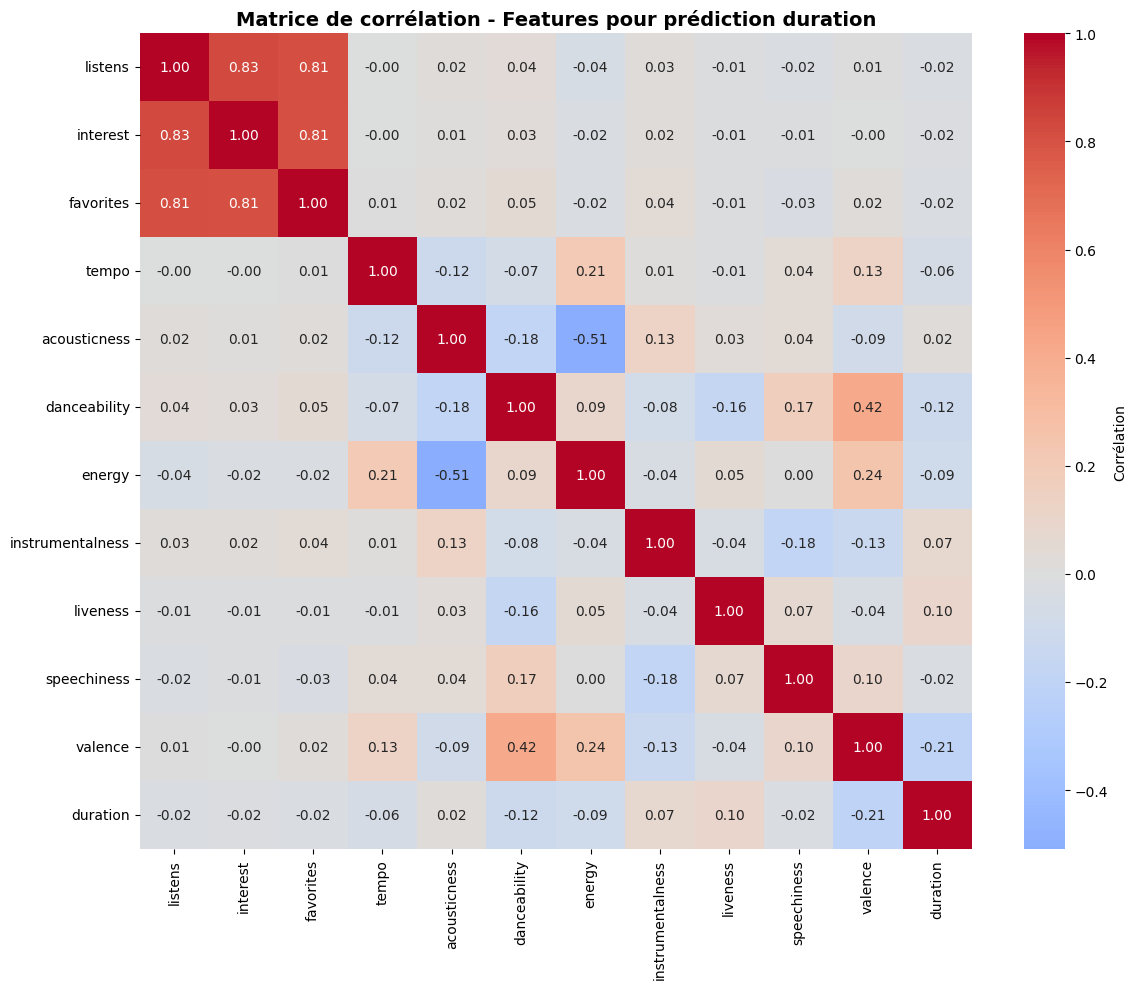

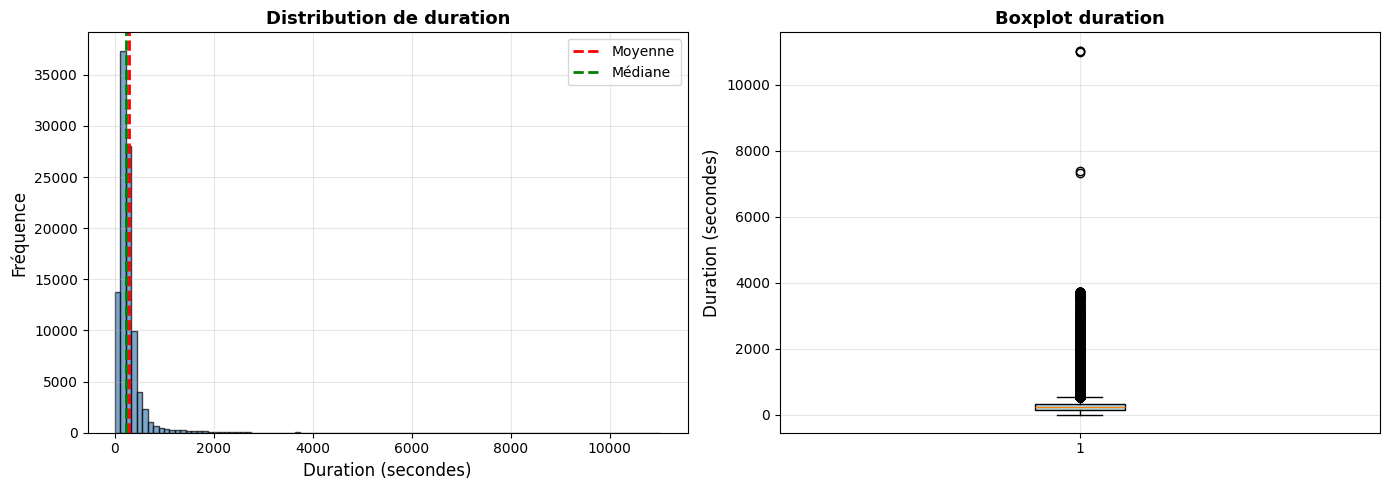

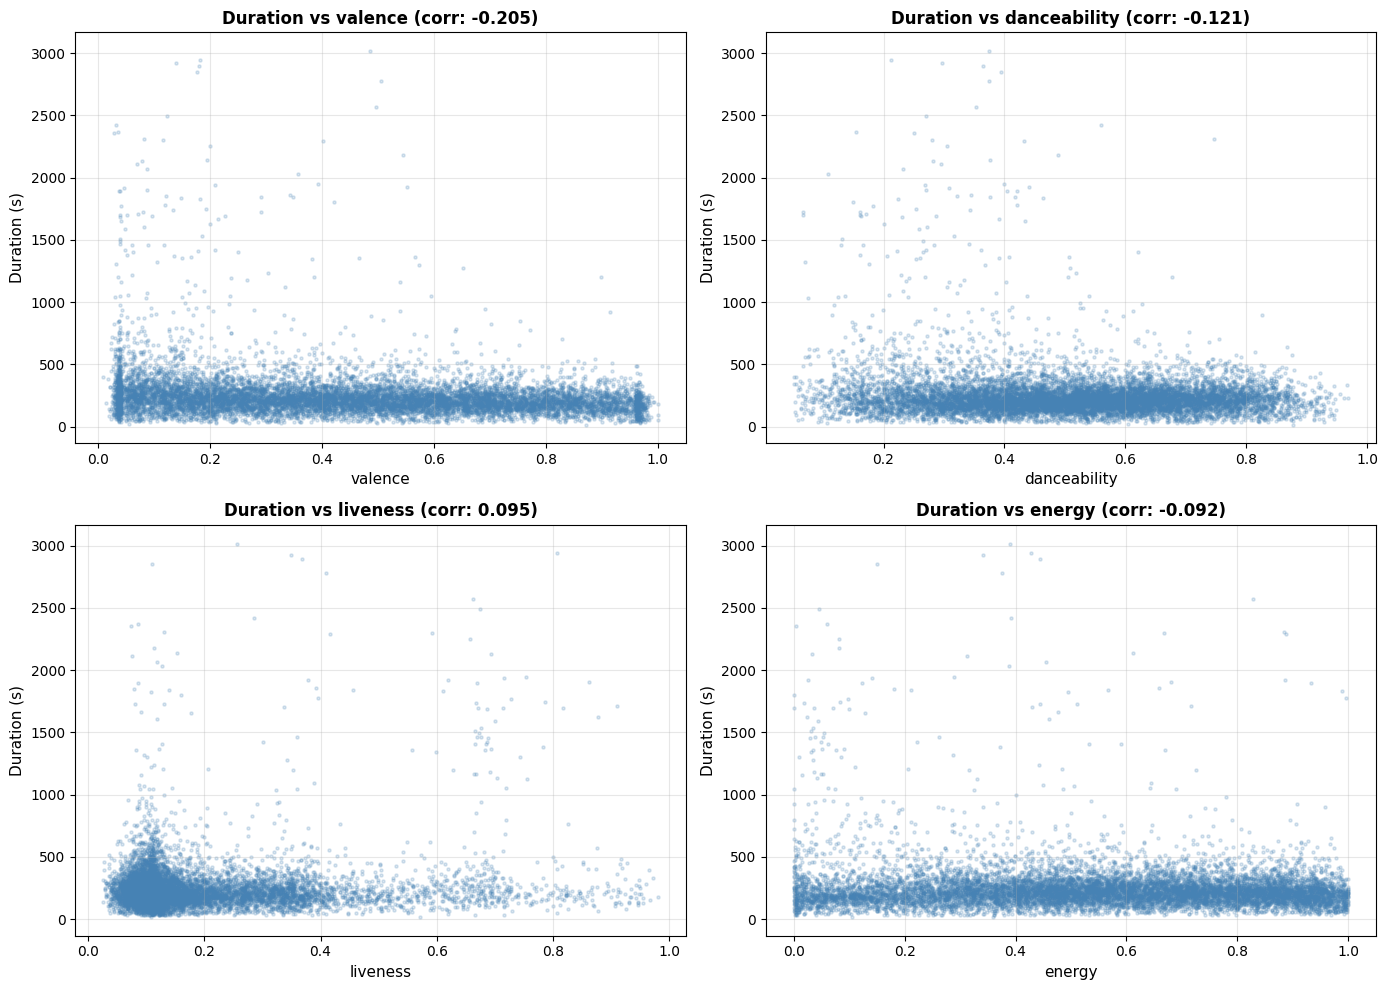

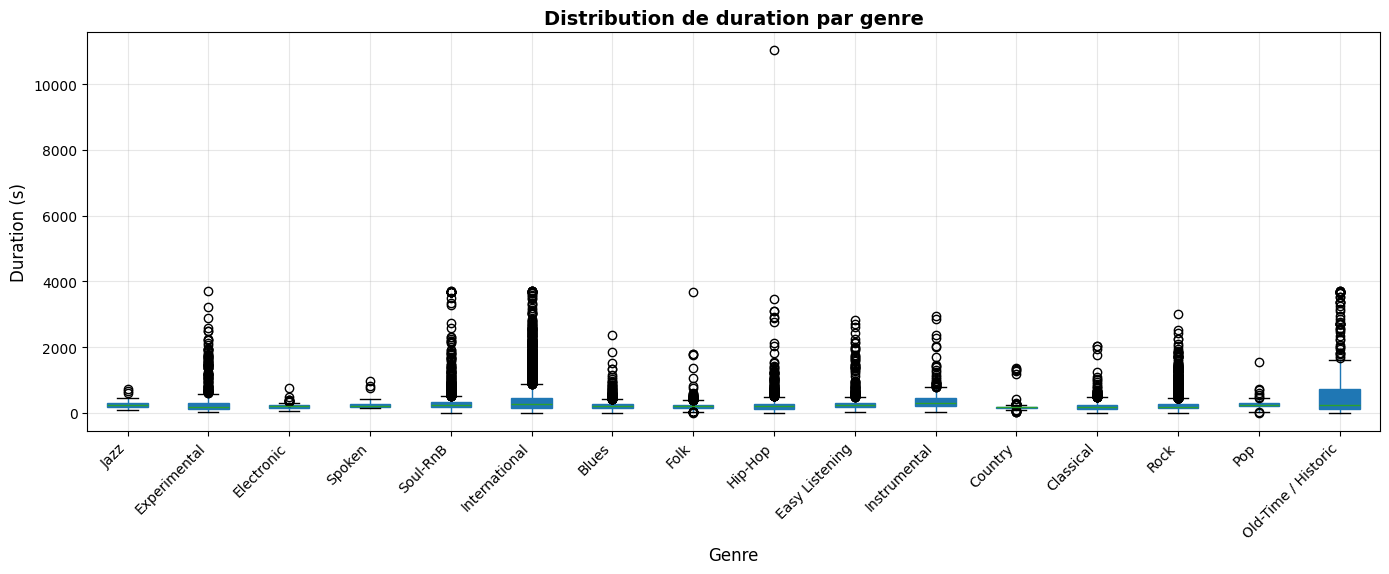


✓ Phase 1 - Points 3 & 4 terminés !


In [62]:
# 1. HEATMAP des corrélations
fig, ax = plt.subplots(figsize=(12, 10))
corr_matrix = df_clean[features_for_regression + ['duration']].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, ax=ax, cbar_kws={'label': 'Corrélation'})
plt.title('Matrice de corrélation - Features pour prédiction duration', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# 2. DISTRIBUTION de duration (target)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogramme
axes[0].hist(df_clean['duration'], bins=100, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].set_xlabel('Duration (secondes)', fontsize=12)
axes[0].set_ylabel('Fréquence', fontsize=12)
axes[0].set_title('Distribution de duration', fontsize=13, fontweight='bold')
axes[0].axvline(df_clean['duration'].mean(), color='red', linestyle='--', linewidth=2, label='Moyenne')
axes[0].axvline(df_clean['duration'].median(), color='green', linestyle='--', linewidth=2, label='Médiane')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Boxplot
axes[1].boxplot(df_clean['duration'], vert=True, patch_artist=True,
                boxprops=dict(facecolor='lightblue'))
axes[1].set_ylabel('Duration (secondes)', fontsize=12)
axes[1].set_title('Boxplot duration', fontsize=13, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# 3. SCATTER PLOTS : duration vs top features
top_features = corr_with_duration.drop('duration').abs().sort_values(ascending=False).head(4).index.tolist()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, feat in enumerate(top_features):
    axes[i].scatter(df_clean[feat], df_clean['duration'], alpha=0.2, s=5, color='steelblue')
    axes[i].set_xlabel(feat, fontsize=11)
    axes[i].set_ylabel('Duration (s)', fontsize=11)
    axes[i].set_title(f'Duration vs {feat} (corr: {corr_with_duration[feat]:.3f})', 
                     fontsize=12, fontweight='bold')
    axes[i].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# 4. DURATION par GENRE (si disponible)
if df_clean['genre_top'].notna().sum() > 0:
    fig, ax = plt.subplots(figsize=(14, 6))
    
    df_with_genre = df_clean[df_clean['genre_top'].notna()].copy()
    genre_order = df_with_genre.groupby('genre_top')['duration'].median().sort_values(ascending=False).index
    
    df_with_genre.boxplot(column='duration', by='genre_top', ax=ax, 
                         positions=range(len(genre_order)), 
                         patch_artist=True)
    ax.set_xticklabels(genre_order, rotation=45, ha='right')
    plt.suptitle('')
    ax.set_title('Distribution de duration par genre', fontsize=14, fontweight='bold')
    ax.set_xlabel('Genre', fontsize=12)
    ax.set_ylabel('Duration (s)', fontsize=12)
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

print("\n✓ Phase 1 - Points 3 & 4 terminés !")
